<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Nearest-Neighbor-Methods" data-toc-modified-id="Nearest-Neighbor-Methods-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Nearest Neighbor Methods</a></span><ul class="toc-item"><li><span><a href="#The-OIL-dataset" data-toc-modified-id="The-OIL-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>The OIL dataset</a></span></li></ul></li></ul></div>

# Nearest Neighbor Methods

In [1]:
# Imports
import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV

from dataset import Dataset

In [3]:
# Setup the dataset
houses = Dataset('./data/houseprices_prepared.csv.gz')
houses.set_target('SalePrice');
# remove de Id, scale numeric features and remove skenwess
houses.drop_columns('Id').scale().ensure_normality()
# Known issues with NA's
houses.replace_na(column='Electrical', value='Unknown')
houses.replace_na(column=houses.names('categorical_na'), value='None')
# Some FE basic stuff to reduce some features by aggregating them
houses.aggregate(['1stFlrSF','2ndFlrSF','BsmtFinSF1','BsmtFinSF2'], 'HouseSF')
houses.aggregate(['OpenPorchSF','3SsnPorch','EnclosedPorch','ScreenPorch',
                  'WoodDeckSF'], 'HousePorch')
houses.aggregate(['FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath'], 
                  'HouseBaths')

My _k-NN_ problem will address the modeling using ONLY the numeric features, so I create a new Dataset called `subset` that will only contain numericals.

In [4]:
subset = pd.concat([houses.select('numerical'), houses.target], axis=1)
subset = Dataset.from_dataframe(subset).set_target('SalePrice')
subset.describe()


Available types: [dtype('float64')]
25 Features
0 categorical features
25 numerical features
0 categorical features with NAs
0 numerical features with NAs
25 Complete features
--
Target: SalePrice


I need to make my problem suitable for a classification algorithm like _k-NN_. So, given that my target variable is a continuous number, I must discretize it, so I decide to bin it, using the convenient method `KBinsDiscretizer` is Scikit Learn. I start by binning in 5 different buckets, but I can change that later. This means that my problem is now a classification problem where the `SalePrice` is now a value between 0 and 4.

In [5]:
saleprice_enc = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
saleprice_enc.fit(subset.target.values.reshape(-1, 1))

y_enc = saleprice_enc.transform(subset.target.values.reshape(-1, 1))
subset.target = pd.Series(y_enc.ravel(), name='SalePrice')

I think I can go for KNN now.

In [6]:
X, y = subset.split()
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X.train.values, y.train.values)

#Predict the response for test dataset
y_pred = knn.predict(X.test.values)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy_score(y.test, y_pred))

Accuracy: 0.773972602739726


Let's find the best value for K, using cross validation

In [29]:
tuned_parameters = [{'n_neighbors': [2,3,5,7,9]}]
scores = ['precision', 'recall']
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    clf = GridSearchCV(KNeighborsClassifier(), 
                       tuned_parameters, 
                       cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X.train, y.train)
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y.test, clf.predict(X.test)
    print(classification_report(y_true, y_pred))

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_neighbors': 5}

Grid scores on development set:

0.529 (+/-0.051) for {'n_neighbors': 2}
0.628 (+/-0.188) for {'n_neighbors': 3}
0.645 (+/-0.161) for {'n_neighbors': 5}
0.593 (+/-0.036) for {'n_neighbors': 7}
0.587 (+/-0.046) for {'n_neighbors': 9}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86       118
         1.0       0.76      0.76      0.76       114
         2.0       0.62      0.62      0.62        40
         3.0       0.67      0.59      0.62        17
         4.0       0.00      0.00      0.00         3

   micro avg       0.77      0.77      0.77       292
   macro avg       0.58      0.57      0.58       292
weighted avg       0.76      0.77      0.77       292


# Tuning hyper-parameters for re

Plot the results using t-SNE. To know more about, refer to this [link](https://distill.pub/2016/misread-tsne/)

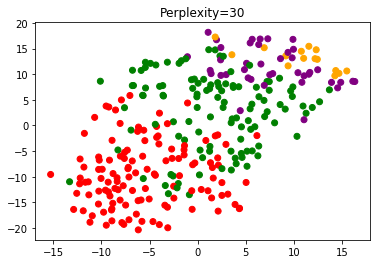

In [26]:
colors = ['red','green','blue','purple','orange']
perplexity=30
X_embedded = TSNE(n_components=2, perplexity=perplexity).fit_transform(X.test)
plt.scatter(X_embedded[:, :1], X_embedded[:, 1:2], 
            c=y_pred.reshape(-1,1),
            cmap=ListedColormap(colors))
plt.title("Perplexity={}".format(perplexity))
plt.show();

In [16]:
for perplexity in perplexities:
    print(np.floor(perplexities.index(perplexity) / 3))

0.0
0.0
0.0
1.0
1.0
1.0


## The OIL dataset

Available [here](http://inverseprobability.com/3PhaseData.html).
Configuration labels, originally as dummy variables:

    [1 0 0] == Homogeneous configuration
    [0 1 0] == Annular configuration
    [0 0 1] == Stratified configuration

We convert them into a single categorical 3-valued character.

In [8]:
oil_labels = Dataset('/Users/renero/Downloads/3PhData/DataTrnLbls.txt', 
                     header=None,
                     sep='  ', 
                     names=['H','A','S'])
# Transform the dummies into the actual category label (column name)
oil_labels.features['target'] = oil_labels.features.idxmax(axis=1)
oil_labels.drop_columns(['H','A','S'])

We read the actual values in the training set, setting the variable names as $x_1$, ... to $x_{12}$.

In [9]:
oil_data = Dataset('/Users/renero/Downloads/3PhData/DataTrn.txt', 
                     header=None,
                     sep='  ', 
                     names=['x{}'.format(i+1) for i in range(12)])

Finally, we merge both datasets to form a single one with the target variable properly set as 'Configuration'.

In [10]:
oil = Dataset.from_dataframe(
    pd.concat([oil_data.features, oil_labels.features], axis=1))

In [11]:
oil.data.head(5)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,target
0,0.3315,0.2156,0.6802,0.1434,0.6825,0.2720,0.6223,0.2092,0.7961,0.1530,0.5856,0.2573,H
1,0.0939,1.0089,0.0365,0.6944,0.0908,0.4961,0.0722,0.6521,-0.0130,0.6085,0.0631,0.6597,A
2,0.5184,0.2283,0.5300,0.6884,0.7456,0.6171,0.6136,0.5928,0.7678,0.6130,0.6705,0.5202,H
3,0.4208,0.6740,0.1651,0.7592,0.1810,0.5448,0.1707,0.7554,0.1635,0.5492,0.2598,0.6455,A
4,0.3130,0.6465,0.5908,0.6924,0.7664,0.6262,1.7177,0.0150,0.0851,1.9046,-0.0165,0.0221,S


In [14]:
oil.set_target('target')
oil.features.head(5)

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
0,0.3315,0.2156,0.6802,0.1434,0.6825,0.2720,0.6223,0.2092,0.7961,0.1530,0.5856,0.2573
1,0.0939,1.0089,0.0365,0.6944,0.0908,0.4961,0.0722,0.6521,-0.0130,0.6085,0.0631,0.6597
2,0.5184,0.2283,0.5300,0.6884,0.7456,0.6171,0.6136,0.5928,0.7678,0.6130,0.6705,0.5202
3,0.4208,0.6740,0.1651,0.7592,0.1810,0.5448,0.1707,0.7554,0.1635,0.5492,0.2598,0.6455
4,0.3130,0.6465,0.5908,0.6924,0.7664,0.6262,1.7177,0.0150,0.0851,1.9046,-0.0165,0.0221


In [8]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html

h = .02  # step size in the mesh
n_neighbors = 5

x_min, x_max = X.test.values[:, :2].min() - 1, X.test.values[:, :2].max() + 1
y_min, y_max = y.test.values.min() - 1, y.test.values.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ValueError: query data dimension must match training data dimension

In [ ]:
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

plt.figure()
plt.pcolormesh(xx, yy, Z)#, cmap=cmap_light)

# Plot also the training points
plt.scatter(X.test.values[:, :1], X.test.values[:, 1:2], c=y.test.values)#, 
            #cmap=cmap_bold,
            #edgecolor='k', 
            #s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("3-Class classification (k = %i)" % n_neighbors)

plt.show()